# Use **ResNet** to do classification on wood and grass

## Data preparation

### Create Test and Val dataset

In [43]:
import os
import shutil
import random

def create_directories():
    # Create necessary directories if they don't exist
    os.makedirs('dataset/train/grass', exist_ok=True)
    os.makedirs('dataset/val/grass', exist_ok=True)
    os.makedirs('dataset/train/wood', exist_ok=True)
    os.makedirs('dataset/val/wood', exist_ok=True)

def split_images(source_folder, train_folder, val_folder, train_ratio=0.7):
    # List all images in the source folder
    images = os.listdir(source_folder)

    # Shuffle the images to ensure randomness
    random.shuffle(images)

    # Calculate the split index
    split_index = int(len(images) * train_ratio)

    # Split the images into training and testing sets
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Move the images to the respective directories
    for image in train_images:
        shutil.copy(os.path.join(source_folder, image), os.path.join(train_folder, image))

    for image in val_images:
        shutil.copy(os.path.join(source_folder, image), os.path.join(val_folder, image))

def main():
    # Create the necessary directories
    create_directories()

    # Split and move grass images
    split_images('grass', 'dataset/train/grass', 'dataset/val/grass')

    # Split and move wood images
    split_images('wood', 'dataset/train/wood', 'dataset/val/wood')

if __name__ == "__main__":
    main()

### Data Augmentation

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torch
import numpy as np
import random

# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [47]:
# Define the data directory
data_dir = 'dataset'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 100, 'val': 72}


['grass', 'wood']

### Load the model

In [48]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name: 
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Use stochastic gradient descent with a learning rate of 0.001 and momentum of 0.9
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Train the Model

In [50]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 0.2763 Acc: 0.9000
val Loss: 0.0236 Acc: 1.0000
train Loss: 0.2202 Acc: 0.9200
val Loss: 0.0593 Acc: 0.9861
train Loss: 0.5011 Acc: 0.8500
val Loss: 0.0562 Acc: 0.9861
train Loss: 0.4094 Acc: 0.8800
val Loss: 0.0147 Acc: 1.0000
train Loss: 0.0453 Acc: 0.9700
val Loss: 0.0314 Acc: 0.9861
Training complete!


In [51]:
# Save the model
torch.save(model.state_dict(), 'grass_wood_classification_model.pth')

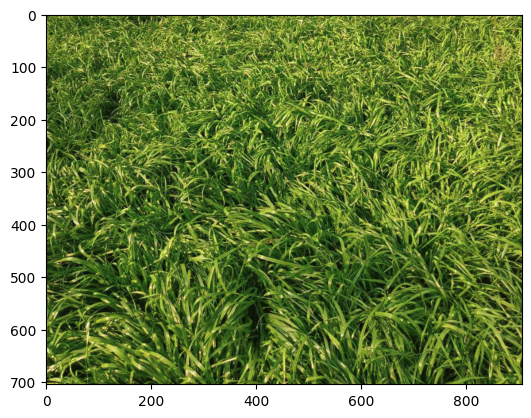

In [53]:
# Show my test image
from PIL import Image
import matplotlib.pyplot as plt

image_path = 'test_image.png'
image = Image.open(image_path)
plt.imshow(image)

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # 1000 is to adjust to match the original model's output units
model.load_state_dict(torch.load('grass_wood_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Our target classes are 2: grass and wood

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

# Load and preprocess the unseen image
image_path = 'test_image.png'  # Replace with the path to your image
image = Image.open(image_path)
image = image.convert('RGB')

# Define the image transformation for the test image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

# Perform inference using the new model
new_model.eval()
with torch.no_grad():
    output = new_model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['grass', 'wood']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: grass


## References
[1] YouTube, https://www.youtube.com/watch?v=mn5QDKQ54dQ&t=975s (accessed Oct. 16, 2024). <br>
[2] AarohiSingla, “Image-classification-using-pytorch/image_classification.ipynb at main · AAROHISINGLA/image-classification-using-pytorch,” GitHub, https://github.com/AarohiSingla/Image-Classification-Using-Pytorch/blob/main/image_classification.ipynb (accessed Oct. 16, 2024). 